# Variational Autoencoder
Based on variational inference

$$P(Z|X) = \frac{P(Z,X)}{P(X)}$$

## Some basic information theory
### Information 
$I = -log(P(x))$
* Measures the factor of uncertainty removed when x is known
* 1 bit can be thought of as information that reduces uncertainty
    by a factor of 2
E.g. Let's say there is 50% chance of weather being sunny and 
50% chance of rain tomorrow. When the weather station tells us it is going to be sunny, they have given us 1 bit of information.

> Uncertainty reduction is the inverse of the event's probability

E.g. If the weather probabilities are sunny 75% and rain 25%,
finding out that it is going to be rainy will reduce our 
uncertainty by $1/0.25 = 4$. This corresponds to $log_2(4) = 2$ bits of information $log_2(\frac{1}{0.25}) = -log_2(0.25)$

### Entropy 
$H = \sum_x-log(P(x)) * P(x))$  
* Can be thought of as average amount of information relayed by a certain distribution
E.g in the above case, the weather station on average transmits
$$ H = 0.75 \times -log(0.75) + 0.25 \times (-log(0.25)) 
  = 0.81$$ bits of useful information

### Cross-entropy
$$H(P,Q) = \sum_x P(x)(-log(Q(x))$$

E.g Lets say we use 2 bits to encode our weather prediction
this can be thought of as us predicting the weather to have
a 25% chance of either being sunny or rainy
The average number of actual bits sent is
$H = 0.75 \times 2 + 0.25 \times 2 = 2 $bits. If using different number of bits for the different predictions $H = 0.75 \times 2 + 0.25 \times 3 = 2.25 $bits 

Based on the entropy and cross-entropy, we can see that our _predicted_ probability distribution Q(x) differs from the _actual_ probability distribution P(x) by 
$KL(P||Q) = 2.25 - 0.81 = 1.54 $bits  
If predictions are perfect i.e. Q(x) = P(x), then H(P,Q) = H(P)  
Therefore, $H(P,Q) = H(P) + KL(P||Q)$  
$KL(P||Q)$ means KL-divergence of Q w.r.t P

\begin{align}
KL(P||Q) &= H(P,Q) - H(P)\\
         &= \sum_x P(x)(-log(Q(x)) -  \sum_xP(x)(-log(P(x))\\
         &= \sum_{x} P(x)(-log(Q(x) - (-log(P(x)))\\
         &= \sum_x P(x)(log(P(x)) - log(Q(x)))\\
         &= \sum_x P(x)(log(\frac{P(x)}{Q(x)}))\\
\end{align}
#### Some properties of KL-divergence
1. $KL(P||Q)$ is alwaysgreater than or equal to 0
2. $KL(P||Q)$ is not the same as $KL(Q||P)$


## Variational Bayes

$$P(Z|X) = \frac{P(Z,X)}{P(X)} = \frac{P(X|Z)P(Z)}{P(X)}$$

We don't know P(X). If we were to compute it,
$P(X) = \int{P(X|Z)P(Z)dZ}$
* Intractable in many cases
* If distributions are high dimensional, integral is multi-integral

Thus, we can try to approximate the distribution. One method to approximate is Monte Carlo method (Gibbs sampling and other sampling methods) which is unbiased with high variance.

Another is variational inference which has low variance but is biased

1. Approximate P(Z|X) with Q(Z) that is tractable e.g. Gaussian
2. Play with the parameters of Q(Z) in a way that it gets close enough to P(Z|X) i.e. minimize $KL(Q(Z)||P(Z|X))$

This brings us to the following objective of minimizing 


\begin{align}
KL(Q(Z)||P(Z|X)) &= \sum_z Q(Z)log(\frac{Q(Z)}{P(Z|X)})\\
                 &= - \sum_zQ(Z) log(\frac{P(Z|X)}{Q(Z)})\\
                 &= - \sum_z Q(Z) log(\frac{P(X,Z)}{P(X) Q(Z)})\\
                 &= - \sum_z Q(Z) (log(\frac{P(X,Z)}{Q(Z)}) - log(P(X)))\\
                 &= - \sum_z Q(Z) log(\frac{P(X,Z)}{Q(Z)}) + log(P(X))\\
\end{align}
\begin{align}
\therefore log(P(X))    &= KL(Q(Z)||P(Z|X)) + \sum_z Q(Z)log(\frac{P(X,Z)}{Q(Z)})\\
                 &= KL(Q(Z)||P(Z|X)) + L\\
\end{align}


As $log(P(X))$ is a constant, to minimize $KL(Q(Z)||P(Z|X))$,
we just need to maximize $L$.

$$\because KL(Q(Z)||P(Z|X)) \geq 0$$,  
$$L \leq P(X)$$ Thus, L is a lower bound of P(X).

\begin{align}
L &= \sum_z Q(Z) log(\frac{P(X,Z)}{Q(Z)})\\
  &= \sum_z Q(Z) log(\frac{P(X|Z)P(Z)}{Q(Z)})\\
  &= \sum_z Q(Z)(log(P(X|Z)) + log(\frac{P(Z)}{Q(Z)}))\\
  &= \sum_z Q(Z) log(P(X|Z))) + \sum_z Q(Z) log(\frac{P(Z)}{Q(Z)})\\
\end{align}

$$\sum_z Q(Z) log(P(X|Z))) = E_{Q(Z)}P(X|Z)$$
$$\sum_z Q(Z) log(\frac{P(Z)}{Q(Z)}) = -KL(Q(Z)||P(Z))$$

Closed form solution for KL-divergence between two univariate Gaussian distributions:
$$ KL(p(z)||q(z)) = log\Big(\frac{\sigma_q}{\sigma_p}\Big) + \frac{\sigma_q + (\mu_q - \mu_p)^2}{2\sigma_p^2} - \frac{1}{2}$$
Therefore our regularizing term given that P(Z) has mean 0 and standard deviation of 1
$$-KL(Q(Z)||P(Z)) = -\Big[-log(\sigma_Q) + \frac{\sigma_Q^2 + \mu_Q^2}{2} - \frac{1}{2}\Big] $$
$KL(Q(Z)||P(Z)) = 0$ when Q(Z) has mean 0 and standard deviation 1
### Representing L as an autoencoder

X --> Q(Z|X) --> Z --> P(X|Z) --> X'

$E_{Q(Z)}P(X|Z)$ term acts as reconstruction error.
$P(X|Z)$ is deterministic meaning one input will get the same output all the time. Thus, it can be considered $P(X|X')$.

If $P(X|X')$ is gaussian
$$P(X|X') = e^{-|X - X'|^2}$$
$$log(P(X|X')) = -|X - X'|^2$$ --> L2 loss

If Bernoulli distribution, will be similar to cross-entropy

So far the network is all deterministic
> To make it probabilistic, 
    encoder should not parametrize Z but instead the parametrize
    the distribution that generates Z i.e. $\mu$ and $\sigma$



In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import traceback
import math
import os


from scipy.misc import imsave
from skimage.transform import resize
from PIL import Image

/home/naren/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
df = pd.read_csv('../train.csv')
labels = np.asarray(df.label).reshape(42000,1)
train_x = np.asarray(df[df.columns[1:]]).reshape(42000,28*28)/255.0
train_x2 = np.asarray(df[df.columns[1:]]).reshape(42000,28,28,1)/255.0

In [ ]:
############################ SIMPLE MODEL ###############################################
mu_data, sigma_data = 3., 1.75
mu_z, sigma_z = 0., 1.
alpha = 0.2
latent_size = 16

tf.reset_default_graph()
X = tf.placeholder(tf.float32, (None, 784))
with tf.name_scope('encoder'): #Gaussian MLP encoder
    en_1 = tf.layers.BatchNormalization()(X)
    en_1 = tf.layers.Dense(512,activation=tf.nn.elu)(en_1)
    en_1 = tf.layers.Dense(512,activation=tf.nn.tanh)(en_1)
    mean = tf.layers.Dense(latent_size)(en_1)
    log_var = tf.layers.Dense(latent_size)(en_1)

Z = tf.random_normal(mean=mu_z,stddev=sigma_z,shape=(tf.shape(mean))) * tf.exp(log_var/2) + mean
de_in = tf.placeholder(tf.float32,(None,latent_size))
with tf.name_scope('decoder'): #Bernoulli MLP decoder
    de_3 = tf.layers.BatchNormalization()(de_in)
    de_3 = tf.layers.Dense(512,activation=tf.nn.tanh)(de_3)
    de_3 = tf.layers.Dense(512,activation=tf.nn.elu)(de_3)
    output = tf.layers.Dense(784,activation=tf.nn.sigmoid)(de_3)
    output = tf.clip_by_value(output,1e-8,1-1e-8)
beta = 1.
recon_loss = tf.reduce_mean(tf.reduce_sum((tf.square(X - output)),axis=1))#tf.keras.losses.binary_crossentropy(X,output) #
#recon_loss = tf.reduce_mean(tf.reduce_sum(X * tf.log(output) + (1-X) * tf.log(1-output), 1))
kl_loss = tf.reduce_mean(0.5 * tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=1))
loss = -(recon_loss + beta*kl_loss)
adam = tf.train.AdamOptimizer()
train = adam.minimize(loss)

In [ ]:
epochs = 100
bs = 1000
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess,'./checkpoints/simple.ckpt')
    try:
        for i in range(epochs):
            np.random.shuffle(train_x)
            print('Ep: ' + str(i))
            for b in range(42):
                sess.run(train,{X:train_x[b*bs:b*bs+1],})#latent_samples:latent_distribution[b*bs:b*bs+1]
                if b % 1 == 0:
                    saver.save(sess,'./checkpoints/simple.ckpt')
                    rl , kl , l = sess.run([recon_loss, kl_loss, loss],{X:train_x[b*bs:b*bs+1],})
                    print("Loss: {}, Recon Loss: {}, KL Loss: {}".format(l,rl,kl))
    except Exception as e:
        traceback.format_exc(e)
    finally:
        saver.save(sess,'./checkpoints/simple.ckpt')
        print('Model saved')
        
    

In [ ]:
####################### CONV MODEL ########################################
k = 9
mu_z, sigma_z = 0., 1.
bs = 1000
latent_size = 16
tf.reset_default_graph()
X = tf.placeholder(tf.float32, (None, 28, 28, 1))
with tf.name_scope('encoder'):
    en1 = tf.layers.Conv2D(64, (k,k))(X)
    en1 = tf.nn.leaky_relu(en1)
    en2 = tf.layers.Conv2D(64, (k,k), strides=(2,2))(en1)
    en2 = tf.nn.leaky_relu(en2)
    flat = tf.keras.layers.Flatten()(en2)
    en5 = tf.layers.Dense(256,activation=tf.nn.tanh)(flat)
    mean = tf.layers.Dense(latent_size)(en5)
    log_var = tf.layers.Dense(latent_size)(en5)

Z = tf.exp(log_var/2) * tf.random_normal(mean=mu_z,stddev=sigma_z,shape=(tf.shape(mean))) + mean
d_in = tf.placeholder(tf.float32,  (None,latent_size))
with tf.name_scope('decoder'):
    de_3 = tf.layers.Dense(512)(d_in)
    de_3 = tf.nn.leaky_relu(de_3)
    de_4 = tf.layers.Dense(512,activation=tf.nn.tanh)(de_3)
    output = tf.layers.Dense(784,activation=tf.nn.sigmoid)(de_4)
    output = tf.clip_by_value(output,1e-7,1-1e-7)
'''
with tf.name_scope('decoder'):
    de1 = tf.layers.Conv2DTranspose(64,(3,3),padding='same',strides=(2,2))(Z)
    de1 = tf.nn.leaky_relu(de1)
    de2 = tf.layers.Conv2DTranspose(64,(7,7))(de1)
    de2 = tf.nn.leaky_relu(de2)
    de3 = tf.layers.Conv2DTranspose(64,(9,9))(de2)
    de3 = tf.nn.leaky_relu(de3)
    output = tf.layers.Conv2DTranspose(1,(3,3),padding='same',activation=tf.nn.sigmoid)(de3)
'''
beta = 1.
X_reshape = tf.reshape(X,[-1,784])
#recon_loss = tf.reduce_mean(tf.reduce_sum(X*tf.log(output) + (1-X) * tf.log(1-output),axis=1))#tf.reduce_sum(tf.square(X - output))
recon_loss = -tf.reduce_mean(tf.reduce_sum(tf.square(X_reshape - output),axis=1))
kl_loss = tf.reduce_mean(0.5 * tf.reduce_sum(-tf.exp(log_var) - tf.square(mean) + 1. + log_var, axis=1))
ELBO = -(recon_loss+kl_loss)
mnist_train = tf.train.AdamOptimizer().minimize(ELBO)#Maximize Lower bound

with tf.Session() as sess:
    writer = tf.summary.FileWriter('logs', sess.graph)
    sess.run(tf.global_variables_initializer())
    #sess.run(mnist_train, {X:train_x[0:bs].reshape((-1,28,28,1))})
    writer.close()
    

In [ ]:
epochs = 100
batch_s = 1000
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess,'./checkpoints/simple.ckpt')
    try:
        for i in range(epochs):
            print('Epoch ' + str(i))
            np.random.shuffle(train_x)
            for b in range(42):
               # Zs = sess.run(Z,{X:train_x2[b*batch_s:b*batch_s + batch_s],})
                sess.run(mnist_train,{X:train_x2[b*batch_s:b*batch_s + batch_s]})
                if b % 1 == 0:
                    saver.save(sess,'./checkpoints/mnist'+str(latent_size)+'.ckpt')
                    l,rl,kl = sess.run([ELBO,recon_loss,kl_loss],{X:train_x2[b*batch_s:b*batch_s + batch_s]})
                    print("Loss: {} R_Loss: {} KL_Loss: {}".format(l,rl,kl))
    except Exception as e:
        traceback.format_exc(e)
    finally:
        saver.save(sess,'./checkpoints/mnist'+str(latent_size)+'.ckpt')
        print('Model saved')


In [29]:

def _merge(images, size, total,resize_factor = 1.0):
        h, w = images.shape[1], images.shape[2]
        h_ = int(h * resize_factor)
        w_ = int(w * resize_factor)
        print(images.shape,h_,w_)
        if len(images.shape) == 4:
            img = np.zeros((h_ * size[0], w_ * size[1],images.shape[3]))
        else:
            img = np.zeros((h_ * size[0], w_ * size[1]))

        for idx, image in enumerate(images):
            i = int(idx % size[1])
            j = int(idx / size[1])

            image_ = resize(image, ( h_,w_))
            if len(images.shape) == 4:
                img[j * h_:j * h_ + h_, i * w_:i * w_ + w_,:] = image_
            else:
                img[j * h_:j * h_ + h_, i * w_:i * w_ + w_] = image_
            if idx == total-1:
                break
        return img
def create_latent_manifold_2d(h_,w_,size,ckpt,data,c_=1):
    with tf.Session() as sess:
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        saver.restore(sess,ckpt)
        z = sess.run(Z, {X:data[0:1]})
        imgs = np.zeros((h_ * size[0], w_ * size[1],c_))
        for i in range(size[0]):
            z[0][0]=10/size[0]*i - 5
            for j in range(size[1]):
                z[0][1] = 10/size[1]*j - 5
                im = sess.run(out, {d_in:z.reshape([-1,2])}).reshape((-1,h_,w_,c_))
                #print(im.shape)
                imgs[i * h_:h_ * i + h_, j * w_:j * w_ + w_,:] = im
                
        return imgs

def create_latent_manifold_nd(h_,w_,size,dims,ckpt):
     with tf.Session() as sess:
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        saver.restore(sess,ckpt)
        imgs = np.zeros((h_ * dims, w_ * size[1]))
        zt = sess.run(Z, {X:train_x2[0:1]})
        max_z = math.ceil(np.max(zt))
        min_z = math.floor(np.min(zt))
        print(max_z,min_z)
        for i in range(dims):
            z = zt
          #  print(z)
            for j in range(size[1]):
                z[0][i] = (max_z - min_z)/size[1]*j - (max_z - min_z)/2
                im = sess.run(output, {d_in:z.reshape([-1,dims])}).reshape((-1,28,28))
                imgs[i * h_:h_ * i + h_, j * w_:j * w_ + w_] = im
                
        return imgs

   

In [ ]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,'./checkpoints/mnist'+str(latent_size)+'.ckpt')
    Zs = sess.run(Z,{X:train_x2[bs:2*bs]})
    print(np.max(Zs), np.min(Zs))
    imgs = sess.run(output,{d_in:Zs}).reshape((-1,28,28))
    result = _merge(imgs, (20,20), 400)
    #plt.imsave(str(latent_size) + 'd_recon_'+str(epochs)+'_epochs.png',result)
    plt.imshow(result, cmap='gray')
    

In [ ]:
'''
Need to change more than one variable for visible effects
'''
with tf.Session() as sess:
    #result=create_latent_manifold_2d(28,28,(20,20))
    result=create_latent_manifold_nd(28,28,(20,20),latent_size,'./checkpoints/mnist{}.ckpt'.format(latent_size))
   # plt.imsave('{}d_latent_manifold.png'.format(latent_size),result)
    plt.imshow(result, cmap='gray')

In [2]:
#################### FEI FACE VAE ##############################
#original imsize 360 x 260
#test 90 x 64
im_shape = (90,64,3)
num_ims = 200
data = np.ndarray((num_ims,im_shape[0],im_shape[1],im_shape[2]))
i=0
for r,d,f in os.walk('../facedataset'):
    for fn in f:
        im = Image.open(r+'/'+fn)
        im = im.resize((im_shape[1], im_shape[0]), Image.ANTIALIAS)
        data[i] = np.asarray(im) / 255.0
        i += 1
        if i is num_ims:
            break
print(data.shape)

(200, 90, 64, 3)


In [14]:
mu_z, sigma_z = 0., 1.
bs = 20
latent_size = 2
tf.reset_default_graph()
X = tf.placeholder(tf.float32, (None,) + im_shape)
with tf.name_scope('encoder'):
    en1 = tf.layers.BatchNormalization()(X)
    en1 = tf.layers.Conv2D(32,(9,9),strides=(2,2))(en1)
    en1 = tf.nn.leaky_relu(en1)
    en2 = tf.layers.Conv2D(32,(2,1),strides=(1,1))(en1)
    en2 = tf.nn.leaky_relu(en2)
    en3 = tf.layers.Conv2D(32,(9,9),strides=(2,2))(en2)
    en3 = tf.nn.leaky_relu(en3)
    en4 = tf.layers.Conv2D(32,(5,5),strides=(1,1))(en3)
    en4 = tf.nn.leaky_relu(en4)
    en5 = tf.layers.Conv2D(32,(1,1),strides=(2,2))(en4)
    en5 = tf.nn.leaky_relu(en5)
    flat = tf.reshape(en5,[-1,576])
    en6 = tf.layers.Dense(256,activation=tf.nn.tanh)(flat)
    mean = tf.layers.Dense(latent_size)(en6)
    log_var = tf.layers.Dense(latent_size)(en6)
Z = tf.exp(log_var/2) * tf.random_normal(mean=mu_z,stddev=sigma_z,shape=(tf.shape(mean))) + mean
d_in = tf.placeholder(tf.float32,  (None,latent_size))
with tf.name_scope('decoder'):
    de1 = tf.layers.BatchNormalization()(d_in)
    de1 = tf.layers.Dense(576)(de1)
    de1 = tf.nn.leaky_relu(de1)
    re1 = tf.reshape(de1,[-1,6,3,32])
    de2 = tf.layers.Conv2DTranspose(32,(1,1),strides=(2,2))(re1)
    de2 = tf.nn.leaky_relu(de2)
    de3 = tf.layers.Conv2DTranspose(32,(5,5),strides=(1,1))(de2)
    de3 = tf.nn.leaky_relu(de3)
    de4 = tf.layers.Conv2DTranspose(32,(9,9),strides=(2,2))(de3)
    de4 = tf.nn.leaky_relu(de4)
    de5 = tf.layers.Conv2DTranspose(32,(3,2),strides=(1,1))(de4)
    de5 = tf.nn.leaky_relu(de5)
    de6 = tf.layers.Conv2DTranspose(32,(9,9),strides=(2,2))(de5)
    de6 = tf.nn.leaky_relu(de6)
    out = tf.layers.Conv2DTranspose(3,(2,2),activation=tf.nn.sigmoid)(de6)
    out = tf.clip_by_value(out,1e-7,1-1e-7)

recon_loss = -tf.reduce_mean(tf.reduce_sum(tf.square(X - out),axis=[1,2,3]))
kl_loss = tf.reduce_mean(0.5 * tf.reduce_sum(-tf.exp(log_var) - tf.square(mean) + 1. + log_var, axis=1))
ELBO = -(recon_loss+kl_loss)
fei_train = tf.train.AdamOptimizer().minimize(ELBO)#Maximize Lower bound

with tf.Session() as sess:
    writer = tf.summary.FileWriter('logs', sess.graph)
    sess.run(tf.global_variables_initializer())
    #sess.run(mnist_train, {X:train_x[0:bs].reshape((-1,28,28,1))})
    writer.close()

print(out.shape,de5.shape,de4.shape,de3.shape,de2.shape)
print(X.shape,en2.shape,en3.shape,en4.shape,en5.shape)

(?, 90, 64, 3) (?, 41, 28, 32) (?, 39, 27, 32) (?, 16, 10, 32) (?, 12, 6, 32)
(?, 90, 64, 3) (?, 40, 28, 32) (?, 16, 10, 32) (?, 12, 6, 32) (?, 6, 3, 32)


In [11]:
epochs = 100
batch_s = 20
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess,'./checkpoints/simple.ckpt')
    try:
        for i in range(epochs):
            print('Epoch ' + str(i))
            np.random.shuffle(data)
            for b in range(int(num_ims/batch_s)):
               # Zs = sess.run(Z,{X:train_x2[b*batch_s:b*batch_s + batch_s],})
                batch = data[b*batch_s:b*batch_s + batch_s]
                #print(batch.shape)
                sess.run(fei_train,{X:batch})
                if b % 1 == 0:
                    saver.save(sess,'./checkpoints/fei'+str(latent_size)+'.ckpt')
                    mu,lv,l,rl,kl = sess.run([mean,log_var,ELBO,recon_loss,kl_loss],{X:data[b*batch_s:b*batch_s + batch_s]})
                    print("Loss: {} R_Loss: {} KL_Loss: {}".format(l,rl,kl))
    except Exception as e:
        traceback.format_exc(e)
    finally:
        saver.save(sess,'./checkpoints/fei'+str(latent_size)+'.ckpt')
        print('Model saved')


Epoch 0
Loss: 1316.599609375 R_Loss: -1316.538818359375 KL_Loss: -0.06079036742448807
Loss: 1331.16162109375 R_Loss: -1327.6134033203125 KL_Loss: -3.548180341720581
Loss: 1250.558349609375 R_Loss: -1185.8087158203125 KL_Loss: -64.74969482421875
Loss: 1224.380859375 R_Loss: -1218.05859375 KL_Loss: -6.322314739227295
Loss: 1082.6439208984375 R_Loss: -1080.797607421875 KL_Loss: -1.8463579416275024
Loss: 1086.2783203125 R_Loss: -1085.240478515625 KL_Loss: -1.037819504737854
Loss: 1023.0377807617188 R_Loss: -1022.9050903320312 KL_Loss: -0.13266530632972717
Loss: 901.1712646484375 R_Loss: -901.1624145507812 KL_Loss: -0.008879811502993107
Loss: 901.8984375 R_Loss: -901.8970947265625 KL_Loss: -0.0013441446935757995
Loss: 921.4951782226562 R_Loss: -921.4918212890625 KL_Loss: -0.0033649213146418333
Epoch 1
Loss: 905.4960327148438 R_Loss: -905.48388671875 KL_Loss: -0.012159289792180061
Loss: 811.0796508789062 R_Loss: -811.0540161132812 KL_Loss: -0.025651996955275536
Loss: 812.0987548828125 R_Loss

Loss: 397.235595703125 R_Loss: -391.086669921875 KL_Loss: -6.1489362716674805
Loss: 343.2633972167969 R_Loss: -335.97869873046875 KL_Loss: -7.284690856933594
Loss: 340.28204345703125 R_Loss: -332.90264892578125 KL_Loss: -7.379392147064209
Loss: 320.5863952636719 R_Loss: -312.69427490234375 KL_Loss: -7.892126560211182
Loss: 386.05999755859375 R_Loss: -379.0136413574219 KL_Loss: -7.046365261077881
Loss: 378.46533203125 R_Loss: -371.0722961425781 KL_Loss: -7.393050193786621
Loss: 389.2510070800781 R_Loss: -381.06365966796875 KL_Loss: -8.187337875366211
Epoch 11
Loss: 332.66912841796875 R_Loss: -323.962890625 KL_Loss: -8.706230163574219
Loss: 394.4616394042969 R_Loss: -386.5172119140625 KL_Loss: -7.944419860839844
Loss: 315.27423095703125 R_Loss: -308.80828857421875 KL_Loss: -6.465928077697754
Loss: 345.45953369140625 R_Loss: -337.4779052734375 KL_Loss: -7.981614589691162
Loss: 367.3575134277344 R_Loss: -358.92315673828125 KL_Loss: -8.434362411499023
Loss: 327.2028503417969 R_Loss: -319.26

Loss: 271.7356872558594 R_Loss: -260.1246032714844 KL_Loss: -11.611078262329102
Loss: 241.7816925048828 R_Loss: -235.0492401123047 KL_Loss: -6.7324538230896
Loss: 288.609130859375 R_Loss: -279.90350341796875 KL_Loss: -8.70564079284668
Loss: 293.0578918457031 R_Loss: -285.15301513671875 KL_Loss: -7.904889106750488
Epoch 21
Loss: 243.2098846435547 R_Loss: -236.13168334960938 KL_Loss: -7.0781989097595215
Loss: 246.01104736328125 R_Loss: -237.5312957763672 KL_Loss: -8.479743957519531
Loss: 281.1443786621094 R_Loss: -273.1195373535156 KL_Loss: -8.024848937988281
Loss: 250.07382202148438 R_Loss: -243.23092651367188 KL_Loss: -6.842894077301025
Loss: 290.60931396484375 R_Loss: -281.4478454589844 KL_Loss: -9.161462783813477
Loss: 275.00347900390625 R_Loss: -267.2740783691406 KL_Loss: -7.729398250579834
Loss: 280.2950439453125 R_Loss: -272.1947326660156 KL_Loss: -8.100300788879395
Loss: 278.7903137207031 R_Loss: -269.564453125 KL_Loss: -9.225865364074707
Loss: 266.507568359375 R_Loss: -259.79183

Loss: 236.4658660888672 R_Loss: -230.40109252929688 KL_Loss: -6.064775466918945
Loss: 252.04379272460938 R_Loss: -244.26095581054688 KL_Loss: -7.782838344573975
Epoch 31
Loss: 233.9949493408203 R_Loss: -226.60202026367188 KL_Loss: -7.392935276031494
Loss: 247.42567443847656 R_Loss: -240.435302734375 KL_Loss: -6.990378379821777
Loss: 261.267822265625 R_Loss: -253.64682006835938 KL_Loss: -7.6210126876831055
Loss: 240.65524291992188 R_Loss: -233.73800659179688 KL_Loss: -6.917229652404785
Loss: 225.23255920410156 R_Loss: -219.0231475830078 KL_Loss: -6.209407329559326
Loss: 257.90570068359375 R_Loss: -250.29342651367188 KL_Loss: -7.612260341644287
Loss: 226.8656463623047 R_Loss: -219.83090209960938 KL_Loss: -7.034738063812256
Loss: 249.29080200195312 R_Loss: -242.35122680664062 KL_Loss: -6.939578056335449
Loss: 250.47982788085938 R_Loss: -242.74072265625 KL_Loss: -7.739100456237793
Loss: 277.56707763671875 R_Loss: -270.0179748535156 KL_Loss: -7.549101829528809
Epoch 32
Loss: 232.58250427246

Loss: 236.84832763671875 R_Loss: -227.86947631835938 KL_Loss: -8.978850364685059
Loss: 253.5821990966797 R_Loss: -246.33840942382812 KL_Loss: -7.243790626525879
Loss: 234.21246337890625 R_Loss: -227.44454956054688 KL_Loss: -6.76791524887085
Loss: 231.96975708007812 R_Loss: -224.28564453125 KL_Loss: -7.6841139793396
Loss: 259.70025634765625 R_Loss: -253.81338500976562 KL_Loss: -5.886866092681885
Loss: 288.1423645019531 R_Loss: -280.2596740722656 KL_Loss: -7.882676124572754
Loss: 255.39817810058594 R_Loss: -247.0487823486328 KL_Loss: -8.349392890930176
Loss: 234.40736389160156 R_Loss: -228.5727081298828 KL_Loss: -5.83465576171875
Loss: 243.59429931640625 R_Loss: -235.6514892578125 KL_Loss: -7.942809104919434
Loss: 215.55548095703125 R_Loss: -208.2731170654297 KL_Loss: -7.282357215881348
Epoch 42
Loss: 263.4905090332031 R_Loss: -256.7177734375 KL_Loss: -6.772744655609131
Loss: 250.8970184326172 R_Loss: -244.4110565185547 KL_Loss: -6.485968112945557
Loss: 234.28590393066406 R_Loss: -227.13

Loss: 226.080810546875 R_Loss: -218.6885986328125 KL_Loss: -7.392204284667969
Loss: 243.11798095703125 R_Loss: -236.58456420898438 KL_Loss: -6.533411979675293
Loss: 219.78184509277344 R_Loss: -213.2876434326172 KL_Loss: -6.494195461273193
Loss: 227.01773071289062 R_Loss: -219.63485717773438 KL_Loss: -7.382870674133301
Loss: 214.23695373535156 R_Loss: -207.6699981689453 KL_Loss: -6.566953182220459
Loss: 232.6564178466797 R_Loss: -226.1426239013672 KL_Loss: -6.5137939453125
Loss: 238.34510803222656 R_Loss: -230.776123046875 KL_Loss: -7.568987846374512
Loss: 219.55836486816406 R_Loss: -212.5178680419922 KL_Loss: -7.040492057800293
Epoch 52
Loss: 243.21170043945312 R_Loss: -236.1033935546875 KL_Loss: -7.108304023742676
Loss: 222.1846466064453 R_Loss: -214.94967651367188 KL_Loss: -7.234968662261963
Loss: 229.71633911132812 R_Loss: -221.8211669921875 KL_Loss: -7.895171165466309
Loss: 217.2779998779297 R_Loss: -210.855224609375 KL_Loss: -6.422780513763428
Loss: 216.99176025390625 R_Loss: -210

Loss: 245.46975708007812 R_Loss: -238.78604125976562 KL_Loss: -6.683709621429443
Loss: 222.07603454589844 R_Loss: -214.6613311767578 KL_Loss: -7.41469669342041
Loss: 234.5142822265625 R_Loss: -227.81396484375 KL_Loss: -6.700314998626709
Loss: 230.59466552734375 R_Loss: -223.69448852539062 KL_Loss: -6.900184631347656
Loss: 228.99880981445312 R_Loss: -220.33316040039062 KL_Loss: -8.665641784667969
Loss: 231.311279296875 R_Loss: -223.79452514648438 KL_Loss: -7.51675271987915
Epoch 62
Loss: 246.58978271484375 R_Loss: -238.16732788085938 KL_Loss: -8.422454833984375
Loss: 225.43447875976562 R_Loss: -217.48184204101562 KL_Loss: -7.952632904052734
Loss: 213.07537841796875 R_Loss: -205.96328735351562 KL_Loss: -7.112095832824707
Loss: 249.38995361328125 R_Loss: -241.41030883789062 KL_Loss: -7.979649543762207
Loss: 251.89349365234375 R_Loss: -244.8125 KL_Loss: -7.080992221832275
Loss: 203.3043975830078 R_Loss: -196.31497192382812 KL_Loss: -6.989432334899902
Loss: 245.8767852783203 R_Loss: -238.78

Loss: 218.9075927734375 R_Loss: -211.5480194091797 KL_Loss: -7.3595757484436035
Loss: 228.44430541992188 R_Loss: -221.16415405273438 KL_Loss: -7.280149936676025
Loss: 233.24661254882812 R_Loss: -224.45254516601562 KL_Loss: -8.794072151184082
Loss: 214.7847137451172 R_Loss: -207.7624053955078 KL_Loss: -7.022313594818115
Epoch 72
Loss: 246.2407684326172 R_Loss: -238.49844360351562 KL_Loss: -7.742331504821777
Loss: 215.81178283691406 R_Loss: -207.82876586914062 KL_Loss: -7.983016014099121
Loss: 212.1540985107422 R_Loss: -204.63589477539062 KL_Loss: -7.518197536468506
Loss: 214.29554748535156 R_Loss: -206.65371704101562 KL_Loss: -7.641831874847412
Loss: 230.43075561523438 R_Loss: -222.4564971923828 KL_Loss: -7.974259853363037
Loss: 224.1227264404297 R_Loss: -216.34182739257812 KL_Loss: -7.780905723571777
Loss: 224.0687713623047 R_Loss: -217.3463592529297 KL_Loss: -6.722405433654785
Loss: 214.46043395996094 R_Loss: -207.8955841064453 KL_Loss: -6.564850807189941
Loss: 211.81556701660156 R_Lo

Loss: 212.47918701171875 R_Loss: -205.74252319335938 KL_Loss: -6.736663818359375
Loss: 220.49217224121094 R_Loss: -212.7145538330078 KL_Loss: -7.777613162994385
Epoch 82
Loss: 204.47801208496094 R_Loss: -197.63796997070312 KL_Loss: -6.840035438537598
Loss: 216.5370635986328 R_Loss: -210.23416137695312 KL_Loss: -6.3029046058654785
Loss: 226.28680419921875 R_Loss: -218.2021484375 KL_Loss: -8.084650039672852
Loss: 239.25555419921875 R_Loss: -232.2198486328125 KL_Loss: -7.035706996917725
Loss: 232.8214874267578 R_Loss: -225.05126953125 KL_Loss: -7.770220756530762
Loss: 196.35316467285156 R_Loss: -188.6025848388672 KL_Loss: -7.750583648681641
Loss: 197.7108612060547 R_Loss: -191.08937072753906 KL_Loss: -6.621496677398682
Loss: 233.41287231445312 R_Loss: -226.02719116210938 KL_Loss: -7.385684013366699
Loss: 212.98931884765625 R_Loss: -206.2477569580078 KL_Loss: -6.7415571212768555
Loss: 215.27987670898438 R_Loss: -208.04067993164062 KL_Loss: -7.239189147949219
Epoch 83
Loss: 224.928451538085

Loss: 198.97445678710938 R_Loss: -191.64413452148438 KL_Loss: -7.330323696136475
Loss: 211.1190185546875 R_Loss: -203.0885772705078 KL_Loss: -8.030447006225586
Loss: 206.7733917236328 R_Loss: -199.94711303710938 KL_Loss: -6.826275825500488
Loss: 213.861572265625 R_Loss: -206.4775848388672 KL_Loss: -7.383991241455078
Loss: 199.22119140625 R_Loss: -191.55313110351562 KL_Loss: -7.668057441711426
Loss: 223.51942443847656 R_Loss: -216.8554229736328 KL_Loss: -6.664000034332275
Loss: 234.12594604492188 R_Loss: -226.4125518798828 KL_Loss: -7.713386535644531
Loss: 224.23208618164062 R_Loss: -216.5296630859375 KL_Loss: -7.702429294586182
Loss: 211.92872619628906 R_Loss: -204.9069061279297 KL_Loss: -7.021822452545166
Loss: 213.10069274902344 R_Loss: -206.1403350830078 KL_Loss: -6.960358619689941
Epoch 93
Loss: 196.0581817626953 R_Loss: -189.58963012695312 KL_Loss: -6.468554496765137
Loss: 215.36093139648438 R_Loss: -208.0695037841797 KL_Loss: -7.291435241699219
Loss: 191.76480102539062 R_Loss: -1

In [24]:
6*3*32*20

11520

INFO:tensorflow:Restoring parameters from ./checkpoints/fei2.ckpt
(25, 90, 64, 3) 90 64


/home/naren/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


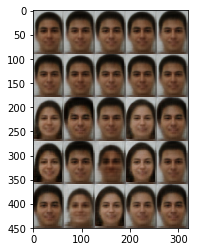

In [23]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,'./checkpoints/fei'+str(latent_size)+'.ckpt')
    Zs = sess.run(Z,{X:data[0:25]})
    imgs = sess.run(out,{d_in:Zs}).reshape((-1,90,64,3))
    result = _merge(imgs, (5,5), 25)
    #plt.imsave(str(latent_size) + 'd_recon_'+str(epochs)+'_epochs.png',result)
    plt.imshow(result)


INFO:tensorflow:Restoring parameters from ./checkpoints/fei2.ckpt


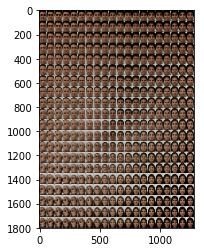

In [34]:
with tf.Session() as sess:
    result=create_latent_manifold_2d(90,64,(20,20),'./checkpoints/fei{}.ckpt'.format(latent_size),data,c_=3)
    #result=create_latent_manifold_nd(28,28,(20,20),latent_size,'./checkpoints/mnist{}.ckpt'.format(latent_size))
    plt.imsave('{}d_latent_manifold_fei.png'.format(latent_size),result)
    plt.imshow(result)